In [1]:
import sklearn
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from clustering import kernelized_k_means_clustering, K_means_clustering

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache = False)

X has 70000 rows and 784 columns. Each row represents a handwritten digit (0 - 9) as 28 * 28 (784) pixels shaped image.
y represents the digit written in an image of row as a string. 

5


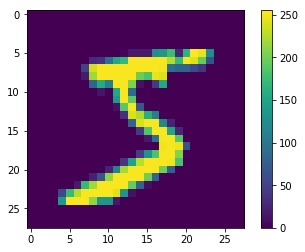

In [3]:
plt.imshow(X[0].reshape(28, -1))
print(y[0])
plt.colorbar()

In [4]:
%%time

clusters = {0: None, 1: None}
data = X[453]
clusters = K_means_clustering(data, clusters)

Converged in: %d iterations 3
CPU times: user 3.23 ms, sys: 1.37 ms, total: 4.6 ms
Wall time: 14.7 ms


In [5]:
clustered_data = np.zeros((len(data), 1))

clustered_data[clusters[0]] = 0
clustered_data[clusters[1]] = 1

0


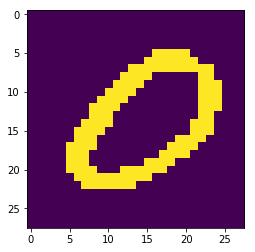

In [6]:
plt.imshow(clustered_data.reshape(28, -1))
print(y[453])

### Kernelized k-means clustering

In [7]:
from clustering import polynomial_kernel

data = X[453]

clusters = {0: np.hstack((range(200), range(600,len(data)))) ,
1: range(200, 600)
}

clusters = kernelized_k_means_clustering(data, clusters, kernel = polynomial_kernel)

Converged in: %d iterations 4


In [8]:
clustered_data = np.zeros((len(data), 1))

clustered_data[clusters[0]] = 0
clustered_data[clusters[1]] = 1

0


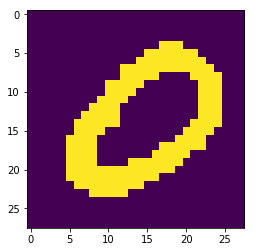

In [9]:
plt.imshow(clustered_data.reshape(28, -1))
print(y[453])